<a href="https://colab.research.google.com/github/mhfaisaluddin/Churn-Prediction-on-Credit-Card-Data/blob/main/temporary_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Churn on Credit Card Customer Data 

# Import Libraries

from google.colab import drive
drive.mount('/content/drive')

In [1]:
# import library
import pandas as pd
import numpy as np

# vis lib
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# preprocessing and composing tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier    
from sklearn.ensemble import RandomForestClassifier 

# hyperparameter tune
from sklearn.model_selection import GridSearchCV

# evaluation metric
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve

# model interpretability
from sklearn.inspection import permutation_importance

# visualization set up
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
palette=['#003566', '#ffa200']

# requirement version
print('Requirement version:')
print('Pandas v', pd.__version__)
print('Numpy v', np.__version__)
print('Matplotlib v', matplotlib.__version__)
print('Seaborn v', sns.__version__)

Requirement version:
Pandas v 1.3.5
Numpy v 1.21.6
Matplotlib v 3.2.2
Seaborn v 0.11.2


# Data Collection

In [2]:
# read the data
df = pd.read_csv('https://raw.githubusercontent.com/mhfaisaluddin/Churn-Prediction-on-Credit-Card-Data/main/BankChurners.csv')
#df = pd.read_csv('BankChurners.csv')

# exclude 2 last columns
data = df[df.columns[:-2]]

data.columns = data.columns.str.lower()
data.head()

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


# Data Understanding

## General Information

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   clientnum                 10127 non-null  int64  
 1   attrition_flag            10127 non-null  object 
 2   customer_age              10127 non-null  int64  
 3   gender                    10127 non-null  object 
 4   dependent_count           10127 non-null  int64  
 5   education_level           10127 non-null  object 
 6   marital_status            10127 non-null  object 
 7   income_category           10127 non-null  object 
 8   card_category             10127 non-null  object 
 9   months_on_book            10127 non-null  int64  
 10  total_relationship_count  10127 non-null  int64  
 11  months_inactive_12_mon    10127 non-null  int64  
 12  contacts_count_12_mon     10127 non-null  int64  
 13  credit_limit              10127 non-null  float64
 14  total_

- The raw data consist of 10127 rows and 21 columns.
- Some categorical data is still in object data types. All of the numerical data are in the correct type.
- The target is `attrition_flag`, customer separated into Attrited Customer (Churn) and Existing Customer.
- No need to use `clientnum` (client number) in this analysis.

**The columns info**
- `clientnum` : Client number. Unique identifier for the customer holding the account
- `attrition_flag` : Internal event (customer activity) variable - if the account is closed then 1 else 0
- `customer_age` : Demographic variable - Customer's Age in Years
- `gender` : Demographic variable - M=Male, F=Female
- `dependent_count` : Demographic variable - Number of dependents
- `education_level` : Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)
- `marital_status` : Demographic variable - Married, Single, Divorced, Unknown
- `income_category` : Demographic variable - Annual Income Category of the account holder in $ (<40K, 40K - 60K, 60K - 80K, 80K-120K, 120K +)
- `card_category` : Product Variable - Type of Card (Blue, Silver, Gold, Platinum)
- `months_on_book` : Period of relationship with bank
- `total_relationship_count` : Total no. of products held by the customer
- `months_inactive_12_mon` : No. of months inactive in the last 12 months
- `contacts_count_12_mon`: No. of Contacts in the last 12 months
- `credit_limit` : Credit Limit on the Credit Card
- `total_revolving_bal` : Total Revolving Balance on the Credit Card
- `avg_open_to_buy` : Open to Buy Credit Line (Average of last 12 months)
- `total_amt_chng_q4_q1` : Change in Transaction Amount (Q4 over Q1)
- `total_trans_amt` : Total Transaction Amount (Last 12 months)
- `total_trans_ct` : Total Transaction Count (Last 12 months)
- `total_ct_chng_q4_q1` : Change in Transaction Count (Q4 over Q1)
- `avg_utilization_ratio` : Average Card Utilization Ratio

**Reference for each CC term :** https://www.creditcards.com/glossary/

- **Revolving balance** is the portion of 'credit card spending' that goes unpaid at the end of a billing cycle.
- **Open-to-Buy**: The difference between the credit limit assigned to a cardholder account and the present balance on the account.
- **Utilization ratio** is used in the calculation of credit scores. It compares the amount of credit being used to the total credit available to the borrower. 

## Data Type
Split the data by its type into numerical and categorical data.

In [4]:
# numerical data
numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
print('Total numerical columns :', data.select_dtypes(include=numerics).shape[1]) # check total columns

# the numerical data
data_num = data.select_dtypes(include=numerics)
data_num.head(3)

Total numerical columns : 15


,clientnum,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
0,768805383,45,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,49,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,51,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000


In [5]:
# categorical data
print('Total categorical columns :', data.select_dtypes(include=['object']).shape[1]) # check total columns

# the categorical data
data_cat = data.select_dtypes(include=['object'])
data_cat.head(3)

Total categorical columns : 6


,attrition_flag,gender,education_level,marital_status,income_category,card_category
0,Existing Customer,M,High School,Married,$60K - $80K,Blue
1,Existing Customer,F,Graduate,Single,Less than $40K,Blue
2,Existing Customer,M,Graduate,Married,$80K - $120K,Blue


# EDA

## Statistical Descriptive

In [6]:
# numerical
data_num.describe()

,clientnum,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


- The variables are at different scales, need to consider using some scalling transformations.
- Some of numerical columns have skewed distribution (mean > median) : `credit_limit`, `avg_open_to_buy`, `total_trans_amt`, and `avg_utilization_ratio`. 
- The value within all columns seems normal by the min-max values.

In [7]:
# categorical
data_cat.describe().T

,count,unique,top,freq
attrition_flag,10127,2,Existing Customer,8500
gender,10127,2,F,5358
education_level,10127,7,Graduate,3128
marital_status,10127,4,Married,4687
income_category,10127,6,Less than $40K,3561
card_category,10127,4,Blue,9436


- The target `attrition_flag` has an imbalance distribution, with `8500 Existing Customer` values. It may need to consider using imbalance handling before modeling.
- The other customer characteristics:
    - Seems balance by the gender
    - 1/3 of total customers is `Graduate`, and have income `Less than $40K`
    - Most of the customers is `Married`
    - `Blue` card user is dominating

## Univariate Analysis Numerical

In [8]:
data_num.describe()

,clientnum,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


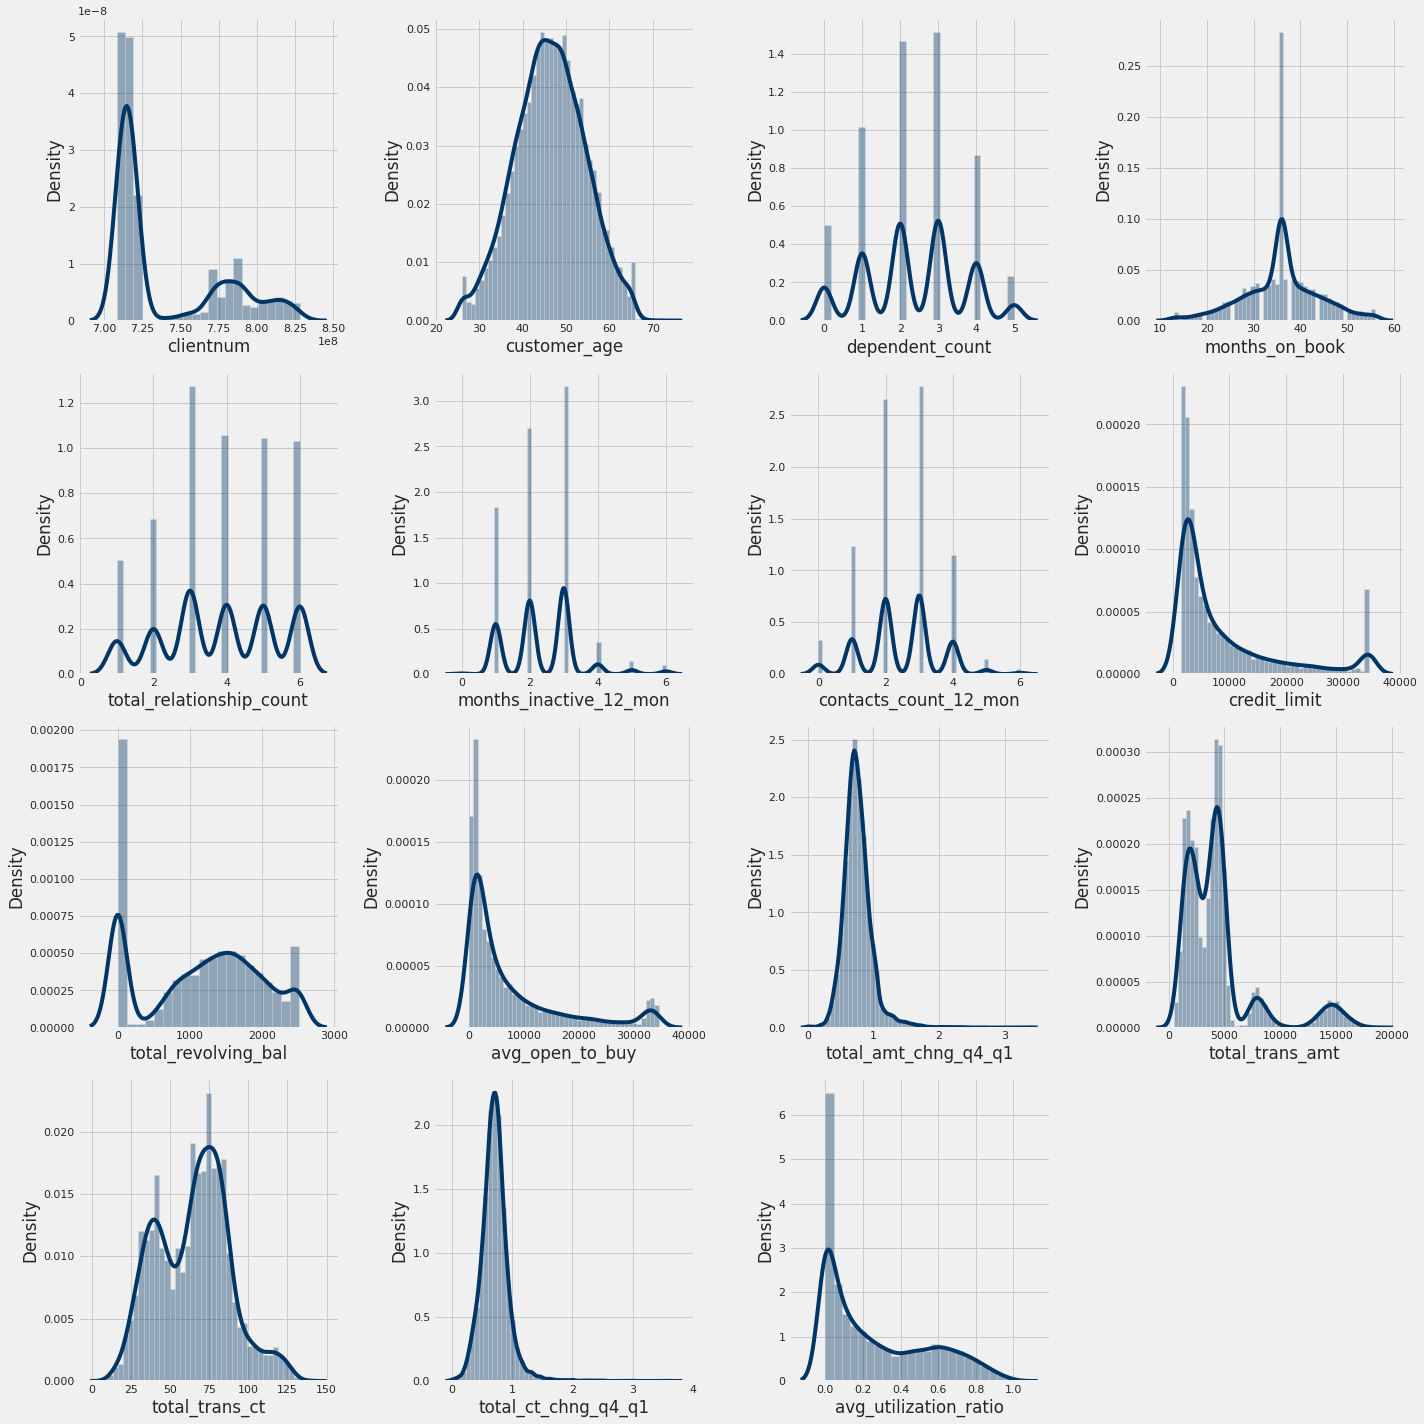

In [9]:
# validating the distribution form using KDE plot 
# setup figure
cols = 4
rows = 4
fig = plt.figure(figsize=(20,20))

# plotting
features = data_num
for i, col in enumerate(features):
    ax = fig.add_subplot(rows, cols, i+1)
    sns.distplot(x=data[col], color=palette[0], ax=ax)
    plt.xlabel(col)
fig.tight_layout()
plt.show()

Most of the feature have a skew distribution, lets see in 4 focused features below.

**4 focused features**

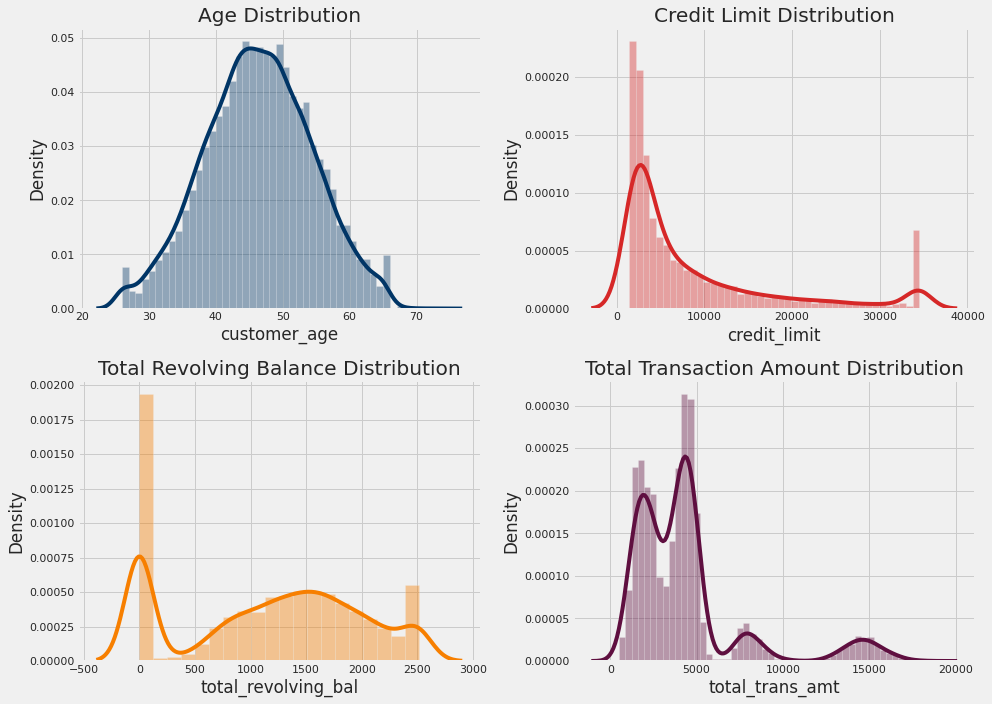

In [10]:
f, ax = plt.subplots(2,2, figsize=(14,10))

g = sns.distplot(data['customer_age'], ax=ax[0,0], color='#003566')
ax[0,0].set_title('Age Distribution')

g = sns.distplot(data['credit_limit'], ax=ax[0,1], color='#d62828')
ax[0,1].set_title('Credit Limit Distribution')

g = sns.distplot(data['total_revolving_bal'], ax=ax[1,0], color='#f77f00')
ax[1,0].set_title('Total Revolving Balance Distribution')

g = sns.distplot(data['total_trans_amt'], ax=ax[1,1], color='#5f0f40')
ax[1,1].set_title('Total Transaction Amount Distribution')

plt.tight_layout()
plt.show()

**Observation**
- `customer_age` with normal distribution, and high density at 40-50 y.o.
- `credit_limit` with a positive skew, mostly distributed under 10k.
- `total_revolving_bal` with a positive skew, and the balance highly distributed in the value < 500, followed by a range of 500-2500.
- `total_trans_amt` with a positive skew, and the amount (last 12 months) was highly distributed at < 5k.

## Univariate Analysis Categorical

In [11]:
# the univariate categoric visualization function
def cat_visual(df, feat, hue):
  df1 = df.groupby(feat)[hue].value_counts(normalize=True)                 # data
  df1 = df1.mul(100).rename('percent').reset_index()

  g = sns.catplot(x=feat, y='percent', hue=hue, kind='bar',                # figure
                  data=df1, height=8, aspect=11/8, palette=palette) 
  g.ax.set_ylim(0,100)

  for p in g.ax.patches:                                                   # percentage
      txt = str(p.get_height().round(2)) + '%'
      txt_x = p.get_x() 
      txt_y = p.get_height()
      g.ax.text(txt_x,txt_y,txt)

  plt.title(label='Distribution of ' + feat.capitalize())
  plt.show()

Credit : https://stackoverflow.com/questions/34615854/seaborn-countplot-with-normalized-y-axis-per-group/59433700#59433700

**Attrition Flag, the Target**

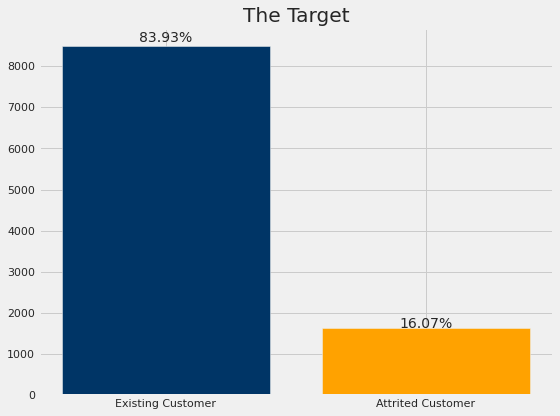

,attrition_flag,freq,percentage
0,Existing Customer,8500,83.93
1,Attrited Customer,1627,16.07


In [12]:
# the target data
attrition = data_cat['attrition_flag'].value_counts().reset_index()                           
attrition.columns = ['attrition_flag', 'freq']
attrition['percentage'] = round((attrition['freq']/attrition['freq'].sum())*100,2)

# the visualization
plt.figure(figsize=(8, 6))                                                                         
graph = plt.bar(attrition.iloc[:,0], attrition.iloc[:,1],     
                color=palette)
plt.title(label='The Target')

# loop for the %-age
i = 0
for p in graph:                                   
    width = p.get_width()                         
    height = p.get_height()                       
    x, y = p.get_xy()                             
    plt.text(x+width/2, y+height*1.01, str(attrition.percentage[i])+'%', ha='center')
    i += 1
plt.tight_layout()
plt.show()
attrition

The target shows an attrition rate dominated by `Existing Customers 84%` a.k.a retained customers, so the data is imbalanced.

Let's see the distribution of the target in each categorical feature.

**Gender**

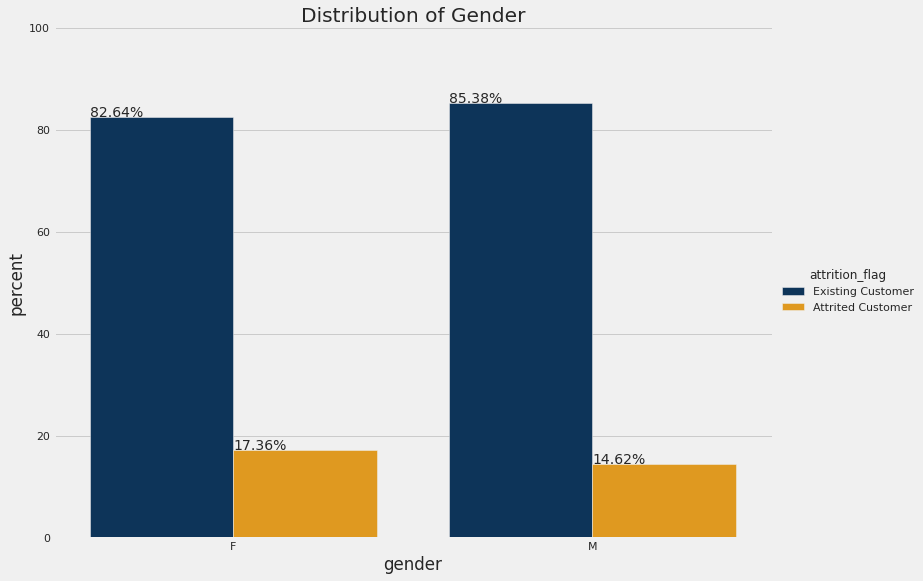

In [13]:
cat_visual(data_cat, 'gender', 'attrition_flag')

The customer's gender is dominated by the female (F) 53%, with the highest churn percentage.

**Education Level**

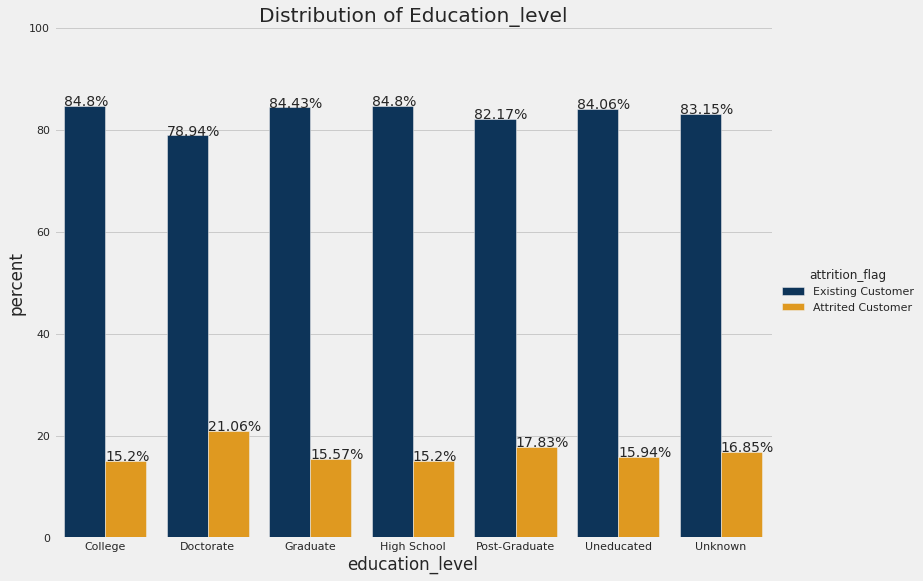

In [14]:
cat_visual(data_cat, 'education_level', 'attrition_flag')

- Graduated customer dominating in education_level.
- Doctorate customer has the highest churn (Attrited Customer) with 20.2% of the portion.
- Unknown value detected, presumably due to unwillingness to fill in the education level.

**Marital Status**

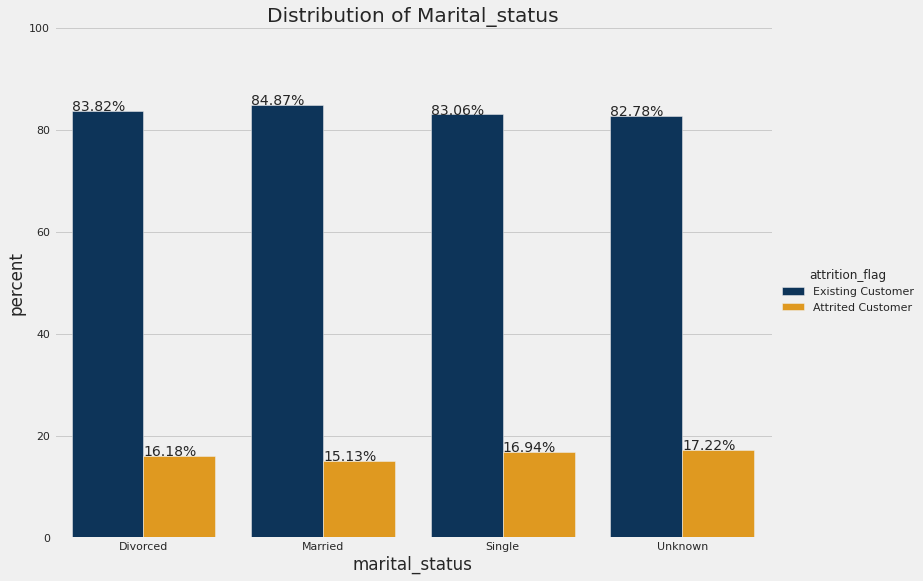

In [15]:
cat_visual(data_cat, 'marital_status', 'attrition_flag')

- Married customer is the highest, while divorced customer is the lowest but with a higher churn rate rather than the others.
- Unknown value detected, presumably due to unwillingness to fill in the marital status.

**Income Category**

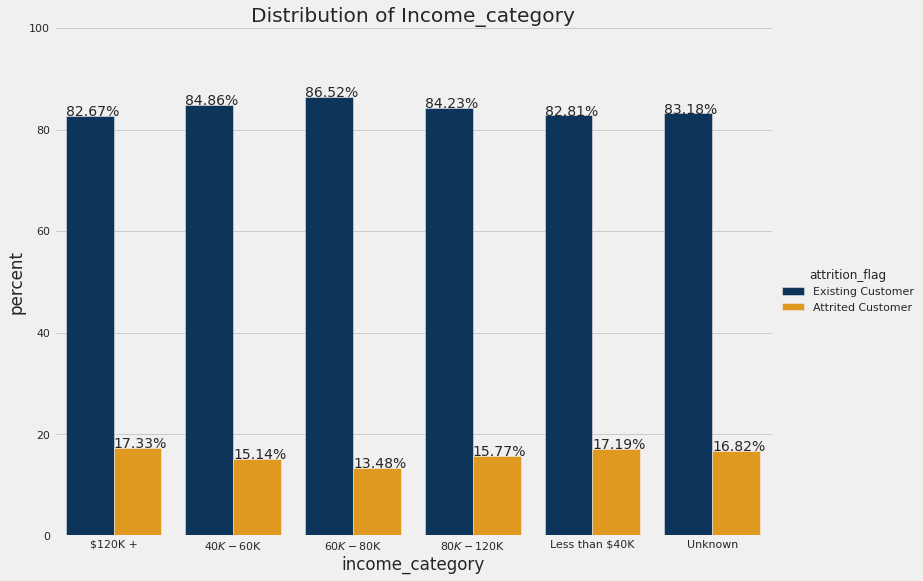

In [16]:
cat_visual(data_cat, 'income_category', 'attrition_flag')

- The most customer has income less than $40K, and be the highest churn rate category.
- An unknown value was found, presumably due to unwillingness to fill in the income.

**Card Category**

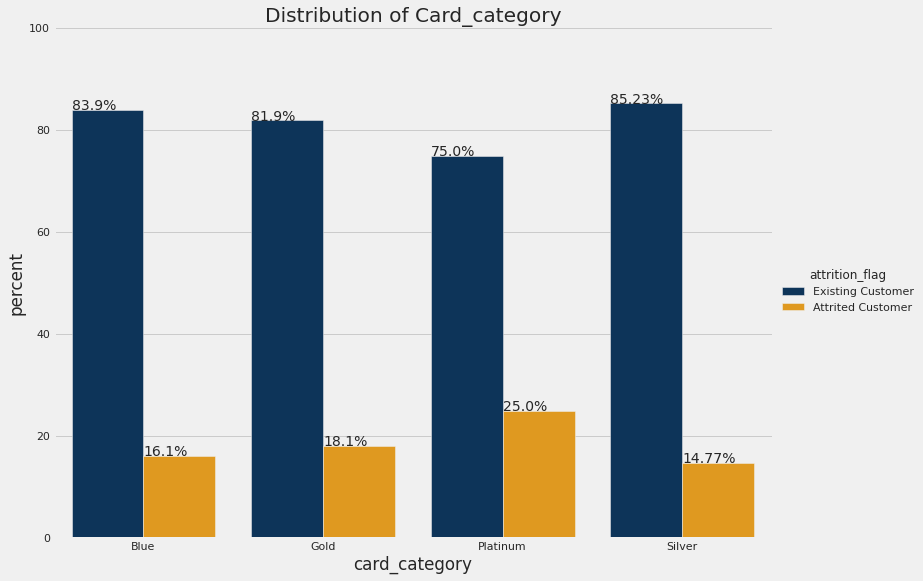

In [17]:
cat_visual(data_cat, 'card_category', 'attrition_flag')

- Most of the customers are Blue card users.
- Gold and Platinum are high-service cards due to the benefit, surprisingly it also has churned customers.

## Multivariate Analysis 

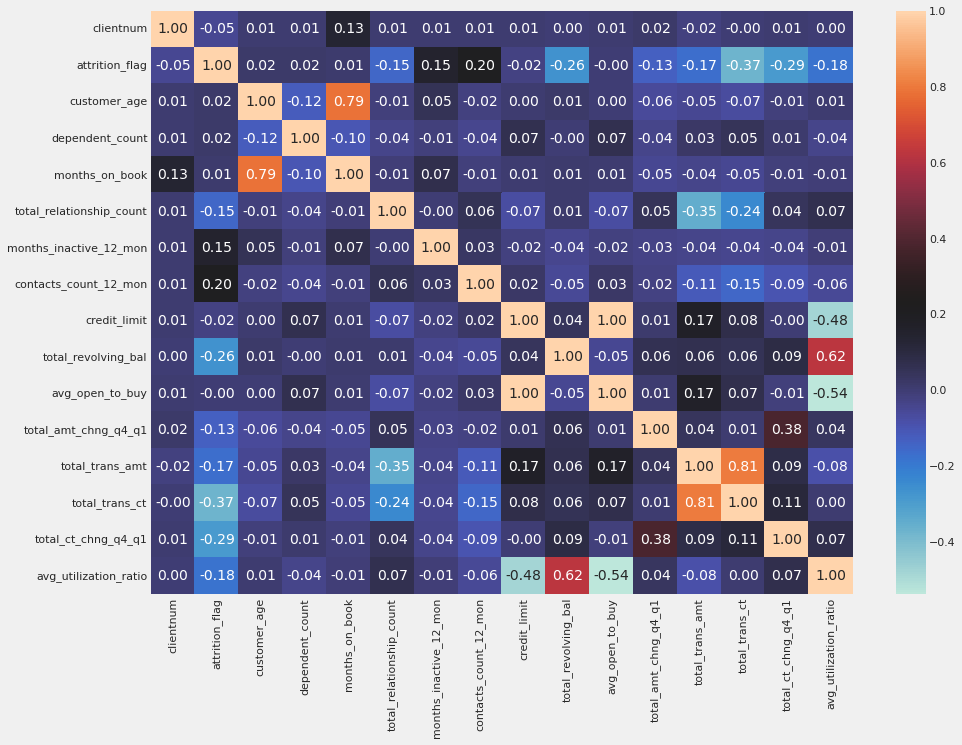

In [18]:
# replace the target to binary
data['attrition_flag'] = data['attrition_flag'].replace({'Existing Customer':0,'Attrited Customer':1}).astype('float64')

# correlation heatmap analysis
plt.figure(figsize=(14,10))
correlation = data.corr()
sns.heatmap(correlation, cmap='icefire', annot=True, fmt='.2f') 

**Observation**

4 pair features have a high-moderate (absolute) correlation value.
- `avg_open_to_buy` with `credit_limit` (1.00)
- `total_trans_ct` with `total_trans_amt` (0.81)
- `months_on_book` with `customer_age` (0.79)
- `avg_utilization_ratio` with `total_revolving_bal` (0.62)

One of the features in each pair will be **removed/dropped before the modeling**, so the model can avoid multicollinearity columns that contain redundant values.

# Data Preprocessing

## Split Data

In [19]:
data_features = data.iloc[:,2:]    
data_target = data.iloc[:,1]      

# train : test = 70 : 30
X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, test_size=0.3, random_state=89)

# check the data after split train-test
print('data_X shape\t:', data_features.shape)
print('data_y shape\t:', data_target.shape)
print()
print('X_train shape\t:', X_train.shape)
print('y_train shape\t:', y_train.shape)
print()
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

data_X shape	: (10127, 19)
data_y shape	: (10127,)

X_train shape	: (7088, 19)
y_train shape	: (7088,)

X_test shape: (3039, 19)
y_test shape: (3039,)


## Missing Values Handling

In [20]:
data.isnull().sum()

clientnum                   0
attrition_flag              0
customer_age                0
gender                      0
dependent_count             0
education_level             0
marital_status              0
income_category             0
card_category               0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
contacts_count_12_mon       0
credit_limit                0
total_revolving_bal         0
avg_open_to_buy             0
total_amt_chng_q4_q1        0
total_trans_amt             0
total_trans_ct              0
total_ct_chng_q4_q1         0
avg_utilization_ratio       0
dtype: int64

There is no NULL data in the dataset, but we detected an 'Unknown' expression at the EDA step. It is found in the `education_level`, `marital_status`, and `income_category` columns.

In [21]:
print("Observations with Unknown values in at least one of the attributes: {} out of {}".format(
    (data[(data["education_level"] == "Unknown") | 
          (data["marital_status"] == "Unknown") | 
          (data["income_category"] == "Unknown")].shape[0]),data.shape[0]))

Observations with Unknown values in at least one of the attributes: 3046 out of 10127


- By the portion above, if treated as a missing value it will cause a **loss of information**. 
- So it will be treated as another category and labeled as zero in the encoding step.

## Multicollinearity Study

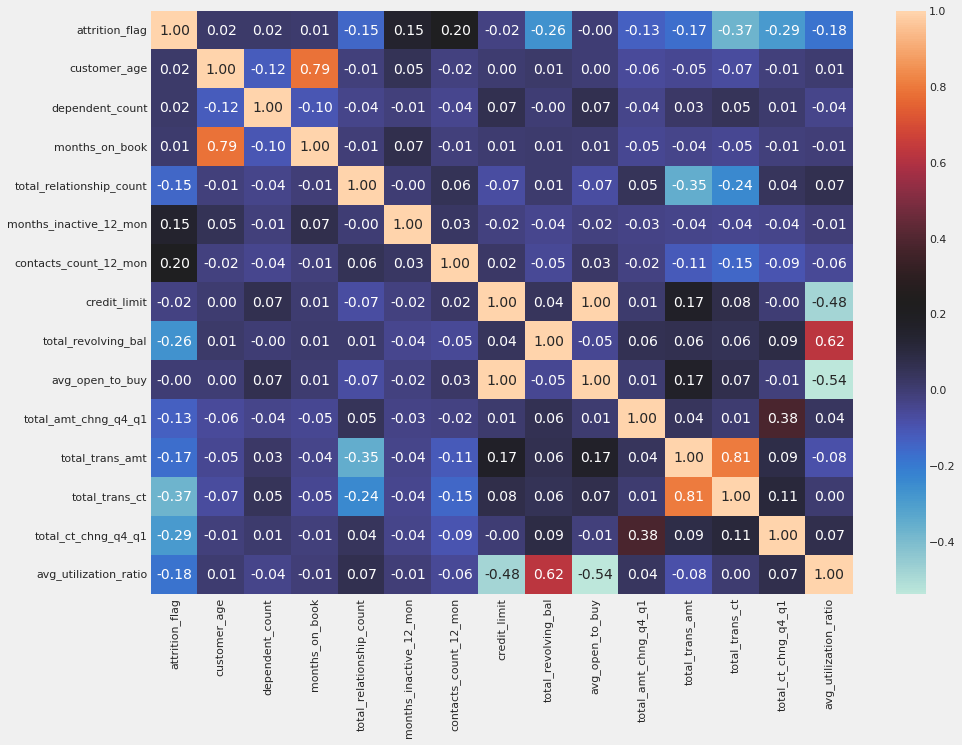

In [22]:
# check multicollinearity by using correlation heatmap 
plt.figure(figsize=(14,10))
correlation = data.iloc[:,1:].corr()
sns.heatmap(correlation, cmap='icefire', annot=True, fmt='.2f')

The each pairs that has a high absolute correlation value (above 0.7)
- `months_on_book` with `customer_age` (0.79)
- `avg_open_to_buy` with `credit_limit` (1.00)
- `total_trans_ct` with `total_trans_amt` (0.81)

After the consecutive trial-error step, we choose to drop `months-on-books`, `avg_open_to_buy`, and `total_trans_ct`.

In [23]:
# drop one feature from each pairs
X_train = X_train.drop(['months_on_book', 'avg_open_to_buy', 'total_trans_ct'], axis=1)

columns_name = X_train.columns
X_test = X_test[columns_name]

## Encoding (Column Transformer)
The encoding step divided into two type, ordinal encoding and one-hot encoding. 
- Ordinal encoding for `education_level`, `income_category`, and `card_category` due to their natural rank ordering values. 
- One-hot encoding for `gender`, and `marital_status` due to their non-ordering values.

In [24]:
# defining the encoding variables
ordinal_enc_variables = ['education_level', 'income_category', 'card_category']
one_hot_enc_variables = ['gender', 'marital_status']

# defining ordinal categories
edu_lvl = ["Unknown", "Uneducated", "High School", "College", "Graduate", "Post-Graduate", "Doctorate"]
income_cat = ["Unknown", "Less than $40K", "$40K - $60K", "$80K - $120K", "$60K - $80K", "$120K +"]
card_cat = ["Blue", "Silver", "Gold", "Platinum"]
attrition_cat = ["Existing Customer", "Attrited Customer"]

# calling the encoder classes
ord_enc = OrdinalEncoder(categories = [edu_lvl, income_cat, card_cat])
one_hot_enc = OneHotEncoder(handle_unknown="ignore")

# the categorical transformer
cat_transformer = make_column_transformer((ord_enc, ordinal_enc_variables),
                                          (one_hot_enc, one_hot_enc_variables),
                                           remainder="passthrough")

# Modeling

## Pipeline & Model Selection
Creating a pipeline in order to organize the preprocessing and modeling code into a single step bundle. 

Try multiple classifier models and evaluate the best model.

**Logistic Regression Classifier as Baseline**

In [25]:
# defining the pipeline
pipeline = Pipeline(
    steps=[('cat_encod', cat_transformer),
           ('SMOTE', SMOTE(random_state=42)),
           ('clf', LogisticRegression(random_state=42))]) #model placeholder

# fit & preds
lr_model = pipeline.fit(X_train, y_train)
preds = lr_model.predict(X_test)

scores = [["Precision score", precision_score(y_test, preds, pos_label = 1)],
          ["Recall score", recall_score(y_test, preds, pos_label = 1)],
          ["F1 score", f1_score(y_test, preds, pos_label = 1)]]

pd.DataFrame(scores, columns=["Metric", "Score"])

,Metric,Score
0,Precision score,0.378274
1,Recall score,0.748560
2,F1 score,0.502577


**KNN Classifier**

In [26]:
# defining the pipeline 
pipeline = Pipeline(
    steps=[('cat_encod', cat_transformer),
           ('SMOTE', SMOTE(random_state=42)),
           ('clf', KNeighborsClassifier())]) #model placeholder
           
# fit & preds
knn_model = pipeline.fit(X_train, y_train)
preds = knn_model.predict(X_test)

scores = [["Precision score", precision_score(y_test, preds, pos_label = 1)],
          ["Recall score", recall_score(y_test, preds, pos_label = 1)],
          ["F1 score", f1_score(y_test, preds, pos_label = 1)]]

pd.DataFrame(scores, columns=["Metric", "Score"])

,Metric,Score
0,Precision score,0.563187
1,Recall score,0.786948
2,F1 score,0.656525


**Decision Tree Classifier**

In [27]:
# defining the pipeline 
pipeline = Pipeline(
    steps=[('cat_encod', cat_transformer),
           ('SMOTE', SMOTE(random_state=42)),
           ('clf', DecisionTreeClassifier(random_state=42))]) #model placeholder

# fit & preds
dt_model = pipeline.fit(X_train, y_train)
preds = dt_model.predict(X_test)

scores = [["Precision score", precision_score(y_test, preds, pos_label = 1)],
          ["Recall score", recall_score(y_test, preds, pos_label = 1)],
          ["F1 score", f1_score(y_test, preds, pos_label = 1)]]

pd.DataFrame(scores, columns=["Metric", "Score"])

,Metric,Score
0,Precision score,0.751852
1,Recall score,0.779271
2,F1 score,0.765316


**Random Forest Classifier**

In [28]:
# defining the pipeline 
pipeline = Pipeline(
    steps=[('cat_encod', cat_transformer),
           ('SMOTE', SMOTE(random_state=42)),
           ('clf', RandomForestClassifier(random_state=42))]) #model placeholder

# fit & preds
rf_model = pipeline.fit(X_train, y_train)
preds = rf_model.predict(X_test)

scores = [["Precision score", precision_score(y_test, preds, pos_label = 1)],
          ["Recall score", recall_score(y_test, preds, pos_label = 1)],
          ["F1 score", f1_score(y_test, preds, pos_label = 1)]]

pd.DataFrame(scores, columns=["Metric", "Score"])

,Metric,Score
0,Precision score,0.903670
1,Recall score,0.756238
2,F1 score,0.823406


**Random Forest model** overcome the other model, so we choose it as best model to get a hyperparemeter tuning.

## Hyperparameter Tuning 
Random Forest hyperparameter tuning
- **max_depth**, defined as the longest path between the root node and the leaf node. It can limit up the depth of every tree in the random forest, in order to control the overfitting in training set.
- **max_features**, it allows the random forest to take variables in individual run. These are the maximum number of features Random Forest is allowed to try in individual tree.
- **n_estimators**, this is the number of trees to construct the forest. The higher value give a stable output but can cause a slower code.

Source : https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/

In [30]:
%%time

# define the model
model = RandomForestClassifier(random_state=42)  

# defining the parameter values
params = {
    'model__max_depth' : [30, None],
    'model__n_estimators': [250, 500],
    'model__max_features': [0.5, "sqrt"]
}

# scoring
scorer = make_scorer(f1_score, pos_label=1)

# wrap up into my_model
my_model = Pipeline(
    steps=[('cat_encode', cat_transformer),
           ('SMOTE', SMOTE(random_state=42)),
           ('model', model)])

# fit to get optimum hyperparameters
optimize_hparams = GridSearchCV(my_model, params, cv=5, scoring=scorer)    # initiate grid
optimize_hparams.fit(X_train, y_train)                                     # run the grid

CPU times: user 8min 2s, sys: 5.05 s, total: 8min 7s
Wall time: 8min 6s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cat_encode',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['Unknown',
                                                                                                     'Uneducated',
                                                                                                     'High '
                                                                                                     'School',
                                                                                                     'College',
                                                                                                     'Graduate',
                                                                                 

## Model Performance Evaluation
We need to build a model with **high precision and sensitivity in predicting churn**, therefore we choose the f1 score (the precision & recall harmonic averages) as the metric evaluation.

In [31]:
# the compact results
cv_rf = pd.DataFrame(optimize_hparams.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
tmp_cv_rf = cv_rf[retain_cols].sort_values('rank_test_score')
tmp_cv_rf.head(3)

,params,mean_test_score,rank_test_score
1,"{'model__max_depth': 30, 'model__max_features'...",0.829615,1
5,"{'model__max_depth': None, 'model__max_feature...",0.829615,1
0,"{'model__max_depth': 30, 'model__max_features'...",0.829574,3


In [32]:
optimize_hparams.best_estimator_

Pipeline(steps=[('cat_encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Unknown',
                                                                              'Uneducated',
                                                                              'High '
                                                                              'School',
                                                                              'College',
                                                                              'Graduate',
                                                                              'Post-Graduate',
                                                                              'Doctorate'],
                                                                             ['Unknown',
                               

The best parameter for the model:<br>
**RandomForestClassifier(max_depth=30, max_features=0.5, n_estimators=500, random_state=42)**

In [33]:
rf_best = optimize_hparams.best_estimator_.fit(X_train, y_train)
y_pred = rf_best.predict(X_test)

# the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      2518
         1.0       0.87      0.85      0.86       521

    accuracy                           0.95      3039
   macro avg       0.92      0.91      0.92      3039
weighted avg       0.95      0.95      0.95      3039



The classification report :
- `87 % precision score`, means out of 100 predicted churn, 88 of them actually churn. So we can say that **the model is quite precise to predicts the churn**.
- `85 % recall score`, means the model succesfully predict 85 from 100 actual churned person. So we can say **the model is quite senstive to detect churn**.

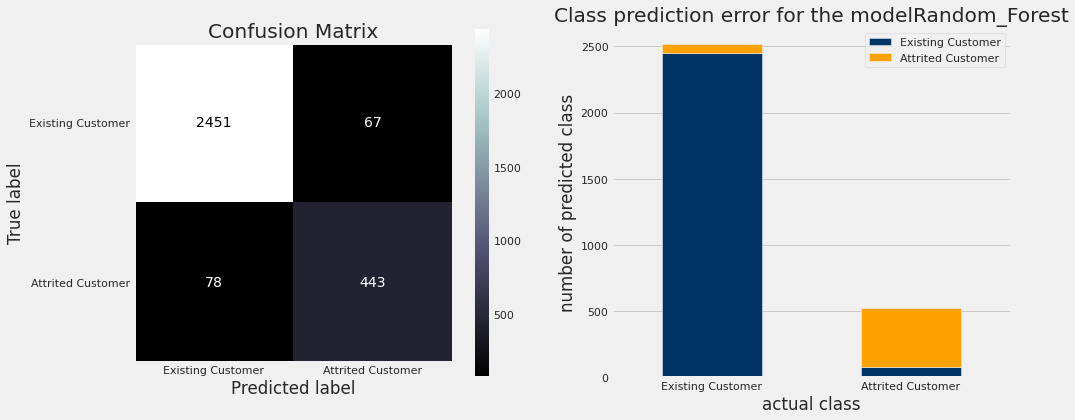

In [34]:
# tmp confusion matrix and the bar version
classifier = rf_best
model_name = 'Random_Forest'
target_labels = ['Existing Customer','Attrited Customer']
fig, axs = plt.subplots(1, 2, figsize=(14,6))

# confusion matrix
cnf_mat = plot_confusion_matrix(classifier, X_test, y_test, labels=[0,1], 
                                display_labels=target_labels, ax=axs[0], cmap='bone')
axs[0].set_title('Confusion Matrix')
axs[0].grid(False)

#Class prediction error
cnf_mat_df = pd.DataFrame(cnf_mat.confusion_matrix, columns=target_labels, index=target_labels)
cnf_mat_df.plot.bar(stacked=True, rot=False, 
                        xlabel='actual class', ylabel='number of predicted class', ax=axs[1], color=palette)
axs[1].set_title('Class prediction error for the model'+model_name)
axs[1].grid(axis='x')

Text(0.5, 1.0, 'Precision-Recall curve')

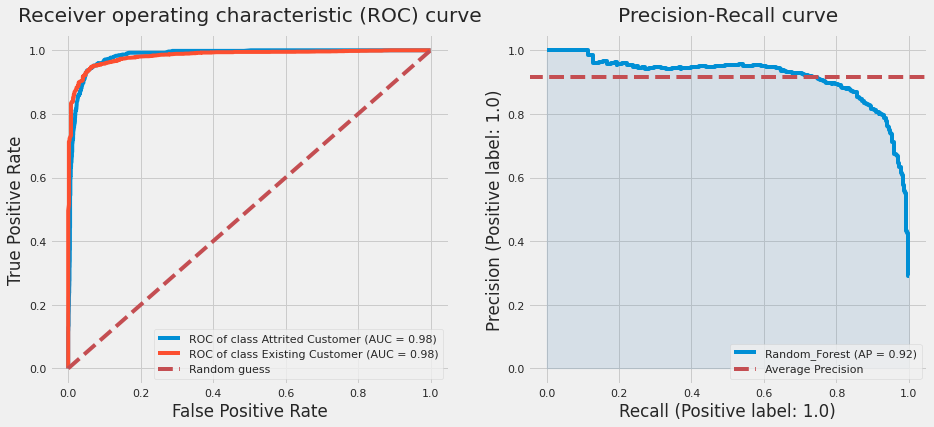

In [35]:
# ROC & precision-recall curve
classifier = rf_best
model_name = 'Random_Forest'
target_labels = ['Existing Customer','Attrited Customer']
fig, axs = plt.subplots(1, 2, figsize=(14,6))

#ROC curve
roc = plot_roc_curve(classifier, X_test, y_test, name='ROC of class ' +target_labels[1], ax=axs[0], pos_label=1)
roc = plot_roc_curve(classifier, X_test, y_test, name='ROC of class '+target_labels[0], ax=axs[0], pos_label=0)
axs[0].set_title('Receiver operating characteristic (ROC) curve', pad=13)
axs[0].plot([0,1],[0,1], 'r--', label='Random guess')
axs[0].set_xlabel(axs[0].get_xlabel().split(' (', 1)[0])
axs[0].set_ylabel(axs[0].get_ylabel().split(' (', 1)[0])
axs[0].legend(loc='lower right')

#Precision-Recall curve
disp = plot_precision_recall_curve(classifier, X_test, y_test, name=model_name, ax=axs[1])
disp.ax_.fill_between(disp.line_._x, disp.line_._y, color="steelblue", alpha=0.15)
disp.ax_.axhline(y=disp.average_precision, color='r', linestyle='--', label="Average Precision")
axs[1].legend(loc='lower right')
axs[1].set_title("Precision-Recall curve", pad=13)

# Model Interpretability

## Permutation Feature Importance 

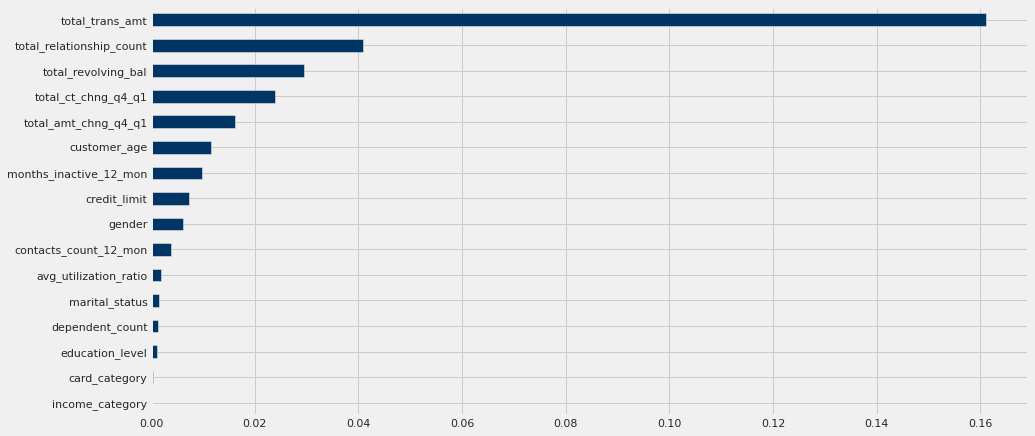

In [36]:
# calculating the result
result = permutation_importance(rf_best, X_test, y_test, n_repeats=10, random_state=42)
forest_importances = pd.Series(result.importances_mean, index=[i for i in X_test.columns])

# visualize the result
plt.figure(figsize=(14,7))
forest_importances.sort_values(ascending=True).plot(kind='barh', color=palette[0])